In [1]:
import hu_core_news_lg
import pandas as pd
import spacy
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

In [2]:
try:
    nlp = spacy.load("hu_core_news_lg")
except:
    print("A nagy modell nem található, a közepeset használjuk...")
    nlp = spacy.load("hu_core_news_md")

In [3]:
nlp = hu_core_news_lg.load()

In [3]:
RAW_CSV = r"../../data/propaganda_articles.csv"      # A nyers, eredeti fájl
PROCESSED_CSV = r"../../data/preprocessed_data_elavult.csv"

In [4]:
csv_file = r"../../data/propaganda_articles.csv"

df = pd.read_csv(csv_file, encoding="utf-8-sig")

In [6]:
df.sample()

,url,title,text,label
1158,https://infostart.hu/sport/2025/12/20/negysanc...,Négysáncverseny: két sztár is visszatér a néme...,"Wellinger és Geiger sem volt jó formában, a kö...",1


In [5]:
df.label.value_counts()

label
0    892
1    841
Name: count, dtype: int64

# Előfeldolgozás

In [6]:
df = df.dropna()

In [15]:
#x = df['title'] + ": " + df['text']
#y = df.label

In [16]:
#x.head(1)

0    A Tisza és a DK nem támogatja a 14. havi nyugd...
dtype: object

In [17]:
#print(x[0])

A Tisza és a DK nem támogatja a 14. havi nyugdíjat + videó: – A 14. havi nyugdíj bevezetése és a gyermekek után járó adókedvezmények növelése gazdaságilag megalapozott, jó döntések, amelyeket a baloldal ellenében is meg kell csinálni – jelentette ki Orbán Viktor a Kossuth rádió reggeli műsorában.

A Tisza és a DK elvenne a nyugdíjasoktól. Fotó: MTI/Bruzák Noémi

A miniszterelnök arról beszélt, hogy az olyan hosszú távú intézkedések bevezetése, mint például a kétgyermekes édesanyáknak járó teljes adómentesség vagy a 14. havi nyugdíj hosszú távú pénzügyi kötelezettséggel járnak.

Ezért az ezekről szóló vita valódi, nyílt végű vita a baloldallal, a DK-val és a Tisza Párttal

– tette hozzá.

A kormányfő szerint az a kérdés, hogy megalapozottak-e a megfontolások, amelyek alapján a döntéseket meghozza a kormány. Orbán Viktor azt állította, hogy a döntéseik megalapozottak, ezeknek megvan a pénzügyi és gazdasági alapja, ezek vállalhatók a baloldal ellenében is, és meg kell csinálni.

A Tisza m

In [318]:
import nltk
import string

## Szövegtisztítás

In [7]:
def spacy_preprocess_pipe(texts, batch_size=50):
    """
    Gyorsabb verzió nlp.pipe használatával és tqdm folyamatjelzővel.
    """
    cleaned_texts = []
    
    # Itt a lényeg: a tqdm-be csomagoljuk az nlp.pipe-ot.
    # A 'total=len(texts)' fontos, hogy tudja, mennyi a 100%.
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["ner", "parser"]), 
                    total=len(texts), 
                    desc="Szöveg előkészítése"):
        
        tokens = []
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            if token.like_num:
                tokens.append("NUM")
            else:
                tokens.append(token.lemma_)
        
        cleaned_texts.append(" ".join(tokens))
    
    return cleaned_texts

In [8]:
def get_training_data():
    # 1. Betöltjük a nyers adatokat
    if not os.path.exists(RAW_CSV):
        raise FileNotFoundError(f"Nincs meg a forrásfájl: {RAW_CSV}")
        
    df_raw = pd.read_csv(RAW_CSV, encoding="utf-8-sig")
    df_raw = df_raw.dropna(subset=['title', 'text', 'url'])
    
    # 2. Megnézzük, van-e már mentett fájl
    if os.path.exists(PROCESSED_CSV):
        df_processed = pd.read_csv(PROCESSED_CSV, encoding="utf-8-sig")
        processed_urls = set(df_processed['url'])
        print(f"Betöltve {len(df_processed)} már feldolgozott cikk.")
    else:
        df_processed = pd.DataFrame(columns=['url', 'cleaned_text', 'label'])
        processed_urls = set()
        print("Még nincs feldolgozott fájl.")

    # 3. Kiszűrjük az újakat
    df_new = df_raw[~df_raw['url'].isin(processed_urls)].copy()

    if df_new.empty:
        print("Nincs új feldolgozandó cikk! A cache-ből dolgozunk.")
    else:
        print(f"Feldolgozás alatt: {len(df_new)} új cikk...")
        
        df_new['full_text'] = df_new['title'] + ": " + df_new['text']
        
        # --- ITT HÍVJUK MEG A TQDM-ES FÜGGVÉNYT ---
        df_new['cleaned_text'] = spacy_preprocess_pipe(df_new['full_text'].tolist())
        
        # 4. Mentés
        df_to_save = df_new[['url', 'cleaned_text', 'label']]
        header_needed = not os.path.exists(PROCESSED_CSV)
        
        df_to_save.to_csv(PROCESSED_CSV, mode='a', index=False, header=header_needed, encoding='utf-8-sig')
        
        # Összefűzés a memóriában
        df_processed = pd.concat([df_processed, df_to_save], ignore_index=True)
        print("Új adatok elmentve.")

    return df_processed['cleaned_text'], df_processed['label']

In [9]:
def spacy_preprocess_one(text):
    """
    Egyetlen string preprocesszálása (inferencia/jóslás idejére).
    Ugyanazt a logikát követi, mint a spacy_preprocess_pipe.
    """
    # 1. Itt simán hívjuk az nlp-t, nem pipe-on keresztül
    # A disable itt is gyorsít, ha csak lemma kell
    doc = nlp(text, disable=["ner", "parser"])
    
    clean_tokens = []
    for token in doc:
        # Ugyanaz a szűrés
        if token.is_stop or token.is_punct:
            continue
        if token.like_num:
            clean_tokens.append("NUM")
        else:
            clean_tokens.append(token.lemma_)
    
    return " ".join(clean_tokens)

In [10]:
x, y = get_training_data()

Betöltve 1435 már feldolgozott cikk.
Feldolgozás alatt: 266 új cikk...


Szöveg előkészítése: 100%|██████████| 266/266 [01:16<00:00,  3.49it/s]

Új adatok elmentve.


In [14]:
y = y.astype(int)

In [15]:
x.sample()

1024    lélektelen falanszter elkészül NER-korszak urb...
Name: cleaned_text, dtype: object

In [16]:
y.value_counts()

label
0    737
1    698
Name: count, dtype: int64

## Szózsák

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [13]:
vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1, max_df=0.9, max_features=2000)
x_counts = vectorizer.fit_transform(x)

## Tfidf

In [14]:
tfidf = TfidfTransformer(sublinear_tf=True)
x_tfidf = tfidf.fit_transform(x_counts)

In [15]:
x_tfidf.shape

(1701, 2000)

In [16]:
# 1. Kinyerjük a szavakat (feature neveket)
feature_names = vectorizer.get_feature_names_out()

# 2. Összegezzük az előfordulásokat oszloponként (axis=0) a teljes adathalmazra
# Az x_counts egy ritka mátrix (sparse matrix), ezért konvertálni kell, vagy a sum-ot használni
sum_words = x_counts.sum(axis=0) 

# 3. Készítünk egy DataFrame-et a szavakból és a darabszámokból
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
# Rendezés gyakoriság szerint csökkenő sorrendbe
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

df_freq = pd.DataFrame(words_freq, columns=['Szó', 'Gyakoriság'])

print("Leggyakoribb 10 kifejezés:")
display(df_freq.head(15))

Leggyakoribb 10 kifejezés:


,Szó,Gyakoriság
0,num,8950
1,magyar,4014
2,év,2225
3,tisza,1937
4,tud,1880
5,orbán,1708
6,párt,1414
7,ember,1386
8,tesz,1372
9,ez,1288


In [17]:
# Átlagos TF-IDF súly kiszámítása
mean_tfidf = x_tfidf.mean(axis=0)
tfidf_scores = [(feature_names[i], mean_tfidf[0, i]) for i in range(len(feature_names))]
tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

df_tfidf_top = pd.DataFrame(tfidf_scores, columns=['Szó', 'Átlag_TFIDF'])
print("\nLegmagasabb TF-IDF értékű szavak:")
print(df_tfidf_top.head(10))


Legmagasabb TF-IDF értékű szavak:
      Szó  Átlag_TFIDF
0     num     0.047141
1  magyar     0.035980
2   tisza     0.028188
3      év     0.025662
4   orbán     0.024511
5      ír     0.022736
6    párt     0.022703
7   péter     0.022428
8     tud     0.022154
9    tesz     0.021081


# Modell

## Train, test, valid

In [18]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_tfidf, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

In [19]:
print(f"Tanító+Validáló készlet mérete: {x_train_full.shape[0]}")
print(f"Végső tesztkészlet mérete: {x_test.shape[0]}") 

Tanító+Validáló készlet mérete: 1445
Végső tesztkészlet mérete: 256


In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
fold = 1
for train_index, val_index in skf.split(x_train_full, y_train_full):
    # Itt jön létre a tényleges szétválasztás a listákra/tömbökre
    x_train, x_valid = x_train_full[train_index], x_train_full[val_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    
    print(f"\n--- {fold}. FOLD ---")
    print(f"Tanító (X_train): {x_train.shape[0]} db")
    print(f"Validációs (X_valid): {x_valid.shape[0]} db")
    print(f"Teszt (X_test): {x_test.shape[0]} db (fix)")
    
    # Itt már használhatod a változókat: X_train, y_train, X_valid, y_valid, X_test, y_test
    fold += 1


--- 1. FOLD ---
Tanító (X_train): 1156 db
Validációs (X_valid): 289 db
Teszt (X_test): 256 db (fix)

--- 2. FOLD ---
Tanító (X_train): 1156 db
Validációs (X_valid): 289 db
Teszt (X_test): 256 db (fix)

--- 3. FOLD ---
Tanító (X_train): 1156 db
Validációs (X_valid): 289 db
Teszt (X_test): 256 db (fix)

--- 4. FOLD ---
Tanító (X_train): 1156 db
Validációs (X_valid): 289 db
Teszt (X_test): 256 db (fix)

--- 5. FOLD ---
Tanító (X_train): 1156 db
Validációs (X_valid): 289 db
Teszt (X_test): 256 db (fix)


## Döntési fa

In [120]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

### különböző fa mélységi értékekkel tanítjuk a fát
valid_f1=[]
train_f1=[]
for d in range(1,40):
  dt = DecisionTreeClassifier(max_depth=d, class_weight="balanced") # döntési fa mélysége
  dt.fit(x_train, y_train)  # tanítunk a tanító adatbázison
  valid_prediction = dt.predict(x_valid)
  valid_f1.append(f1_score(y_valid, valid_prediction, pos_label=1)) # kiértékelés a validációs halmazon
  train_prediction = dt.predict(x_train)
  train_f1.append(f1_score(y_train, train_prediction, pos_label=1)) # a tanító adatbázison is kiértékeljük a túltanulási vizsgálatokhoz

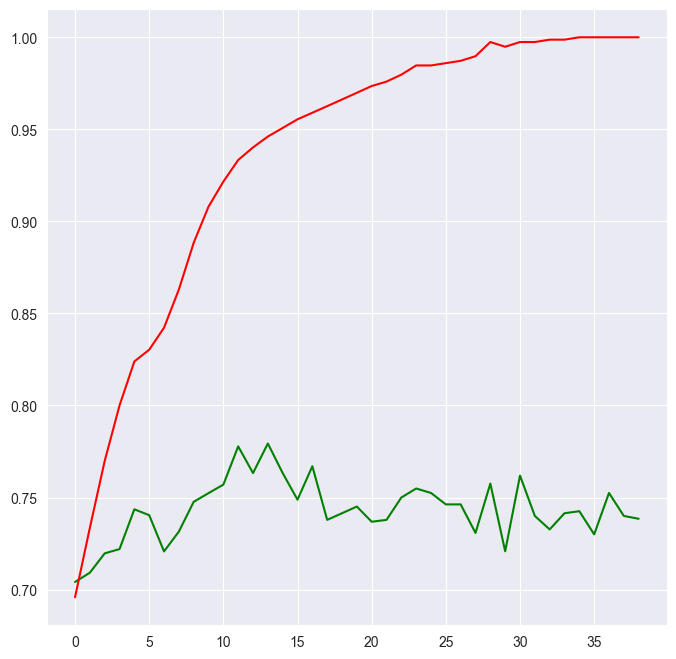

In [121]:
### jelenítsük meg az eredményeket
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(valid_f1, c="green")
plt.plot(train_f1, c="red")

In [122]:
maximum = 0
max_ind = -1
for s, i in enumerate(valid_f1):
    if i > maximum:
        maximum = i
        max_ind = s+1
print(max_ind, maximum)

14 0.7793427230046949


Választva: max_depth = 25 (f1=0.8679245283018868)

In [123]:
dt = DecisionTreeClassifier(max_depth=13, class_weight="balanced")
dt.fit(x_train, y_train) 

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",13
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [124]:
valid_prediction = dt.predict(x_valid)
valid_pred_value = f1_score(y_valid, valid_prediction, pos_label=1)
print(valid_pred_value)

0.7570093457943925


In [125]:
test_prediction = dt.predict(x_test)
test_pred_value = f1_score(y_test, test_prediction, pos_label=1)
print(test_pred_value)

0.6810810810810811


In [126]:
from sklearn.metrics._classification import classification_report
print(classification_report(y_test, test_prediction))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65        92
           1       0.63      0.74      0.68        85

    accuracy                           0.67       177
   macro avg       0.67      0.67      0.67       177
weighted avg       0.67      0.67      0.67       177



In [89]:
accuracy_score(y_train, dt.predict(x_train))

0.7967581047381546

In [127]:
from  sklearn. metrics._classification import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)


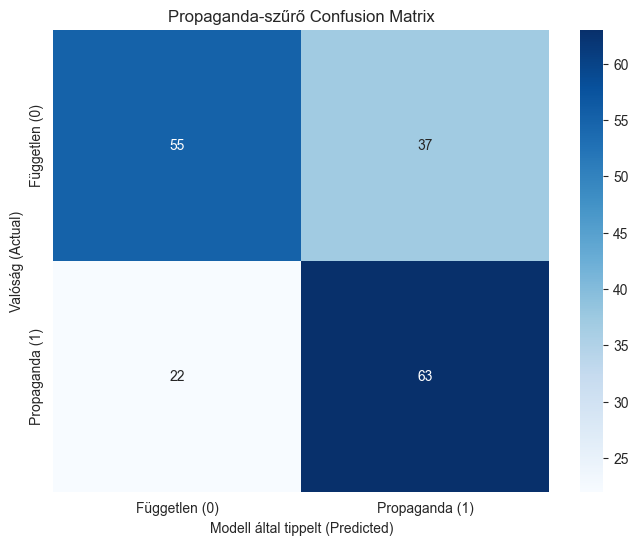

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Független (0)', 'Propaganda (1)'], 
            yticklabels=['Független (0)', 'Propaganda (1)'])

plt.xlabel('Modell által tippelt (Predicted)')
plt.ylabel('Valóság (Actual)')
plt.title('Propaganda-szűrő Confusion Matrix')
plt.show()

## Grid Search

In [341]:
param_grid = {
    'max_depth': [i for i in range(1,40)],
    # Hány adat kell ahhoz, hogy egyáltalán megpróbáljon kettéágazni egy csomópont
    'min_samples_split': [2, 5, 10, 20],
    
    # Hány adatnak kell minimum maradnia egy "levélben" (ág végén)
    'min_samples_leaf': [1, 2, 5, 10, 20],
    
    # A tisztaság mérésének módja (a log_loss az entropy modernebb változata)
    'criterion': ['gini', 'entropy', 'log_loss'],
    
    # Hány kulcsszót vegyen figyelembe egy-egy döntésnél (pl. az összeset vagy csak a gyökét)
    'max_features': [None, 'sqrt', 'log2'],
    
    # Hogyan válassza ki a kettévágást: a legjobb helyen, vagy véletlenszerűen (túltanulás ellen jó)
    'splitter': ['best', 'random'],
    
    # Súlyozás: ha több a propaganda cikked, ezzel kiegyenlítheted az arányokat
    'class_weight': [None, 'balanced']
}

In [342]:
dt = DecisionTreeClassifier(random_state=42)

In [343]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(x_train_full, y_train_full)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': [None, 'balanced'], 'criterion': ['gini', 'entropy', ...], 'max_depth': [1, 2, ...], 'max_features': [None, 'sqrt', ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for e

In [344]:
print(f"Legjobb paraméterek: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Legjobb paraméterek: {'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}


Legjobb paraméterek: {'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Accuracy: 0.69

In [345]:
test_prediction = best_model.predict(x_test)
print(classification_report(y_test, test_prediction))

              precision    recall  f1-score   support

           0       0.69      0.48      0.56        42
           1       0.64      0.81      0.72        48

    accuracy                           0.66        90
   macro avg       0.66      0.64      0.64        90
weighted avg       0.66      0.66      0.64        90



### Próba

In [29]:
from newspaper import Article

def ujAdat(modell, url):
    try:
        # 1. Letöltés
        article = Article(url)
        article.download()
        article.parse()
        
        # Cím + szöveg összefűzése
        raw_text = article.title + ": " + article.text
        
        if len(article.text) < 50:
            return ["Hiba (túl rövid szöveg)", 0]

        # 2. PREPROCESSZÁLÁS (ITT HASZNÁLJUK AZ ÚJ FÜGGVÉNYT)
        # Ez átalakítja: "Orbán Viktor elment..." -> "orbán viktor elmegy..."
        clean_text = spacy_preprocess_one(raw_text)

        # 3. Vektorizálás (CSAK transform, fit nélkül!)
        # A clean_text egy string, de a transform listát vár, ezért kell a []
        x_counts = vectorizer.transform([clean_text])
        x_tfidf = tfidf.transform(x_counts)

        # 4. Jóslás
        tipp_index = modell.predict(x_tfidf)[0]
        probas = modell.predict_proba(x_tfidf)[0]
        
        label = "Propaganda" if tipp_index == 1 else "Független"
        
        biztonsag = float(probas[tipp_index])

        return [label, biztonsag]

    except Exception as e:
        print(f"Hiba: {e}")
        return ["Hiba", 0]

In [30]:
def teszt(modell):
    teszt = [
        ["Független", "https://telex.hu/belfold/2025/12/19/digitalis-polgari-korok-dpk-alapitas-facebook-orban-viktor-fidesz-digitalis-demokraciafejlesztesi-ugynokseg"],
        ["Független", "https://telex.hu/belfold/2025/12/19/a-szolo-utcai-ugy-sulyos-fejlemenyei-ellenere-tovabbra-is-fenntartjak-a-tuzson-jelentes-eredeti-tartalmat"],
        ["Független", "https://telex.hu/belfold/2025/12/19/lazar-janos-komment-strompova-viktoria-elnezest-ker"],
        ["Független", "https://telex.hu/belfold/2025/12/19/kekfeny-szolo-utca-archivum-torolt-video-juhasz-peter-pal"],
        ["Független", "https://telex.hu/kulfold/2025/12/19/eu-europai-tanacs-ukrajna-tamogatas"],
        ["Független", "https://telex.hu/transtelex/2025/12/19/egyfeszt-adossagok-magyarorszagi-tamogatasok-fesztival"],
        ["Propaganda", "https://www.origo.hu/kulpol/2025/12/hatalmas-magyar-siker-brusszelben-orban-viktor-ismertet"],
        ["Propaganda", "https://www.origo.hu/kulpol/2025/12/putyin-oroszorszag-kesz-befejezni-a-konfliktust"],
        ["Propaganda", "https://www.origo.hu/belpol/2025/12/fidesz-kdnp-nott-a-jobboldal-elonye-decemberben"],
        ["Propaganda", "https://www.origo.hu/nagyvilag/2025/12/trump-halal-zelenszkij-tul-messzire-ment"],
        ["Propaganda", "https://www.origo.hu/kulpol/2025/12/orban-viktor-brusszel-eu-csucs-sajtotajekoztato"],
        ["Propaganda", "https://www.origo.hu/belpol/2025/12/minimalber-tisza-ado-orban-viktor-kossuth-elo-origo"]
    ]
    talalat = 0
    for elvart, url in teszt:
        cimke, bizt = ujAdat(modell, url)
        
        # f-string formázás: .2% beszorozza 100-zal és kiteszi a jelet
        print(f"{elvart:10} -> Modell tippje: {cimke:10} | Biztonság: {bizt:.2%}")
        
        if elvart == cimke:
            talalat += 1
    print(f'Találatok száma: {talalat}')
    print(f'Találatok aránya: {talalat/len(teszt)}')

# Random Forest Classifier

In [150]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
print(classification_report(y_test, rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        92
           1       0.79      0.79      0.79        85

    accuracy                           0.80       177
   macro avg       0.80      0.80      0.80       177
weighted avg       0.80      0.80      0.80       177



In [151]:
valid_f1=[]
train_f1=[]
n_estimators = [i for i in range(50, 501, 50)]

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, class_weight="balanced", min_samples_leaf=5, min_samples_split=10, max_features='sqrt')
    rf.fit(x_train, y_train)  # tanítunk a tanító adatbázison
    valid_prediction = rf.predict(x_valid)
    valid_f1.append(f1_score(y_valid, valid_prediction, pos_label=1)) # kiértékelés a validációs halmazon
    train_prediction = rf.predict(x_train)
    train_f1.append(f1_score(y_train, train_prediction, pos_label=1)) # a tanító adatbázison is kiértékeljük a túltanulási vizsgálatokhoz

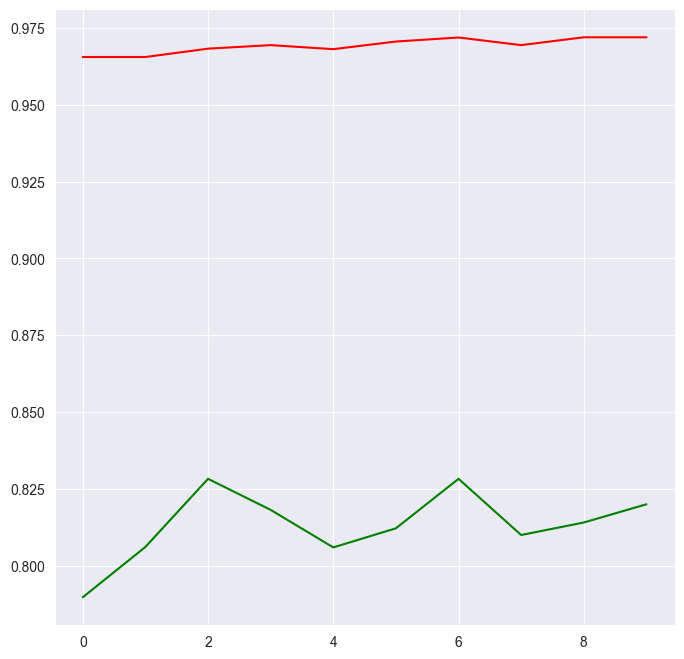

In [152]:
### jelenítsük meg az eredményeket
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(valid_f1, c="green")
plt.plot(train_f1, c="red")

In [153]:
best_n_est_v = -1
best_n_est_ind = -1
for s, i in enumerate(valid_f1):
    if i > best_n_est_v:
        best_n_est_v = i
        best_n_est_ind = s
best_n_est = n_estimators[best_n_est_ind]
print(f'Legjobb eredmény: {best_n_est_v} ({best_n_est} a(z) {best_n_est_ind} indexen)')

Legjobb eredmény: 0.8282828282828283 (150 a(z) 2 indexen)


### Grid Search

In [352]:
param_grid = {
    "max_depth": [5, 10, 15, 20, 25],         # ne legyen túl nagy, hogy ne memorálja az adatot
    "min_samples_split": [5, 10, 15],         # mikor spliteljen egy node-ot, nagyobb -> kevesebb overfit
    "min_samples_leaf": [2, 5, 10],           # kis levél méret segít a simább döntésben
    "max_features": ["sqrt"],                 # sqrt a TF-IDF-nél stabil, log2 is próbálható
    "class_weight": ["balanced"]              # kiegyenlíti a propaganda/független arányt
}

In [353]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

In [354]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(x_train_full, y_train_full)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': ['balanced'], 'max_depth': [5, 10, ...], 'max_features': ['sqrt'], 'min_samples_leaf': [2, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter

In [355]:
print(f"Legjobb paraméterek: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Legjobb paraméterek: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5}


Legjobb paraméterek: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 50}

In [356]:
rf = best_model

### Végső modell - kiértékelés

In [154]:
rf = RandomForestClassifier(n_estimators=150, random_state=42, min_samples_leaf=5, min_samples_split=15, max_features='sqrt')
rf.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",150
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",15
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

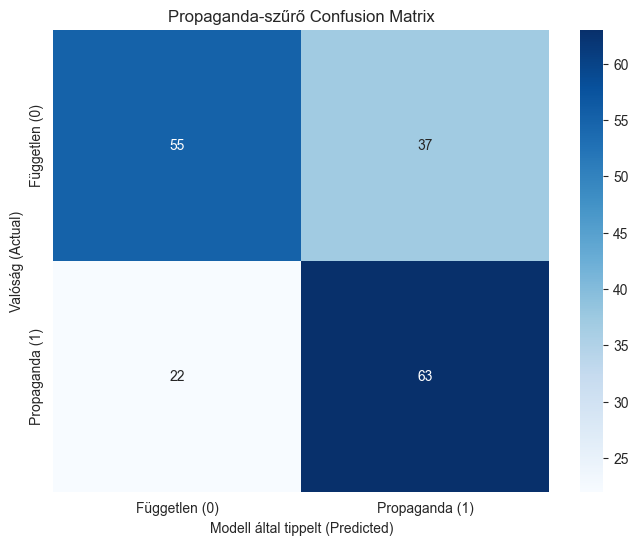

In [155]:
from  sklearn. metrics._classification import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Független (0)', 'Propaganda (1)'], 
            yticklabels=['Független (0)', 'Propaganda (1)'])

plt.xlabel('Modell által tippelt (Predicted)')
plt.ylabel('Valóság (Actual)')
plt.title('Propaganda-szűrő Confusion Matrix')
plt.show()

In [156]:
print(classification_report(y_test, rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        92
           1       0.78      0.80      0.79        85

    accuracy                           0.80       177
   macro avg       0.80      0.80      0.80       177
weighted avg       0.80      0.80      0.80       177



In [101]:
teszt(rf)

Független ['Független', '61.87%']
Független ['Független', '62.63%']
Független ['Független', '50.29%']
Független ['Független', '70.76%']
Független ['Propaganda', '51.15%']
Független ['Független', '67.50%']
Propaganda ['Propaganda', '55.21%']
Propaganda ['Propaganda', '72.08%']
Propaganda ['Propaganda', '81.64%']
Propaganda ['Független', '53.64%']
Propaganda ['Propaganda', '82.15%']
Propaganda ['Propaganda', '81.85%']
Találatok száma: 10
Találatok aránya: 0.8333333333333334


In [361]:
from sklearn.metrics._classification import accuracy_score
accuracy_score(y_test, rf.predict(x_test))

0.7888888888888889

In [362]:
accuracy_score(y_train, rf.predict(x_train))

0.9826732673267327

# LinearSVC

In [22]:
from sklearn.svm import LinearSVC
svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=5000
)
svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [23]:
from sklearn.metrics._classification import classification_report
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       130
           1       0.79      0.79      0.79       126

    accuracy                           0.80       256
   macro avg       0.80      0.80      0.80       256
weighted avg       0.80      0.80      0.80       256



## Finomhangolás

In [25]:
from sklearn.metrics import f1_score
# 1. Listák inicializálása (ez hiányzott!)
valid_f1 = []
train_f1 = []
C_values = []

# 2. Ciklus
# A range(-7, 5) jó: 10^-7 -től 10^4 -ig megy
for l in range(-7, 5):
    C = 10**l
    C_values.append(C)
    
    # LinearSVC létrehozása
    # Tipp: dual="auto" javasolt újabb sklearn verzióknál, ha n_samples > n_features
    lin = LinearSVC(
        random_state=42,
        max_iter=20000, # Érdemes növelni, ha "ConvergenceWarning"-ot kapsz
        class_weight="balanced",
        C=C,
        dual="auto" # Ha sklearn > 1.3 verziód van, ez segít a gyorsulásban és konvergenciában
    )
    
    lin.fit(x_train, y_train)
    
    # Predikció
    valid_pred = lin.predict(x_valid)
    train_pred = lin.predict(x_train)
    
    # Score mentése
    valid_f1.append(f1_score(y_valid, valid_pred, pos_label=1))
    train_f1.append(f1_score(y_train, train_pred, pos_label=1))

    print(f"C={C:.1e} kész.") # Opcionális: látod hol tart

C=1.0e-07 kész.
C=1.0e-06 kész.
C=1.0e-05 kész.
C=1.0e-04 kész.
C=1.0e-03 kész.
C=1.0e-02 kész.
C=1.0e-01 kész.
C=1.0e+00 kész.
C=1.0e+01 kész.
C=1.0e+02 kész.
C=1.0e+03 kész.
C=1.0e+04 kész.


C:\Users\leven\PycharmProjects\propaganda\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


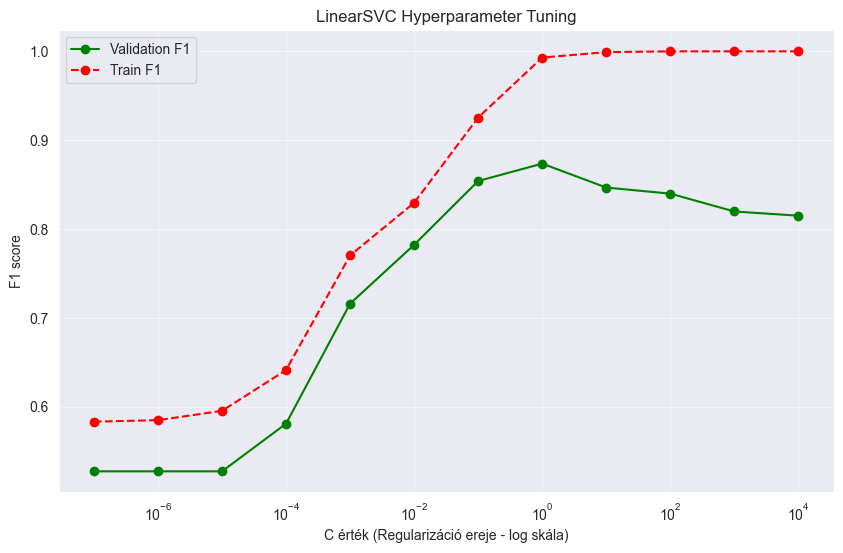

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(C_values, valid_f1, label="Validation F1", marker="o", color="green")
plt.plot(C_values, train_f1, label="Train F1", marker="o", color="red", linestyle="--")

plt.xscale("log")  # EZ TÖKÉLETES ÍGY!
plt.xlabel("C érték (Regularizáció ereje - log skála)")
plt.ylabel("F1 score")
plt.title("LinearSVC Hyperparameter Tuning")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

In [27]:
svc = LinearSVC(random_state=0,
                           max_iter=20000,
                           class_weight="balanced",
                           C=10**(0),
                           dual="auto")

In [28]:
svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo 

In [29]:
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       130
           1       0.79      0.79      0.79       126

    accuracy                           0.80       256
   macro avg       0.80      0.80      0.80       256
weighted avg       0.80      0.80      0.80       256



In [38]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv=5)
calibrated_svc.fit(x_train, y_train)

# 2. Lekérjük a valószínűségeket a tesztkészletre
probs = calibrated_svc.predict_proba(x_test)
preds = calibrated_svc.predict(x_test)

# 3. Nézzünk meg pár példát (Pl. az első 5 cikk)
for i in range(5):
    confidence = probs[i][preds[i]] * 100  # A megjósolt osztály valószínűsége %-ban
    label = "Propaganda" if preds[i] == 1 else "Nem propaganda"
    print(f"{i+1}. cikk jóslata: {label} ({confidence:.2f}%-os biztonsággal)")

1. cikk jóslata: Nem propaganda (89.60%-os biztonsággal)
2. cikk jóslata: Nem propaganda (60.44%-os biztonsággal)
3. cikk jóslata: Propaganda (97.81%-os biztonsággal)
4. cikk jóslata: Nem propaganda (88.33%-os biztonsággal)
5. cikk jóslata: Nem propaganda (79.99%-os biztonsággal)


In [39]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       111
           1       0.86      0.88      0.87       105

    accuracy                           0.87       216
   macro avg       0.87      0.87      0.87       216
weighted avg       0.87      0.87      0.87       216



In [40]:
teszt(calibrated_svc)

Független  -> Modell tippje: Független  | Biztonság: 95.16%
Független  -> Modell tippje: Független  | Biztonság: 96.55%
Független  -> Modell tippje: Független  | Biztonság: 93.10%
Független  -> Modell tippje: Független  | Biztonság: 98.38%
Független  -> Modell tippje: Független  | Biztonság: 78.26%
Független  -> Modell tippje: Független  | Biztonság: 97.26%
Hiba: Article `download()` failed with HTTPSConnectionPool(host='www.origo.hu', port=443): Read timed out. (read timeout=7) on URL https://www.origo.hu/kulpol/2025/12/hatalmas-magyar-siker-brusszelben-orban-viktor-ismertet
Propaganda -> Modell tippje: Hiba       | Biztonság: 0.00%
Hiba: Article `download()` failed with HTTPSConnectionPool(host='www.origo.hu', port=443): Read timed out. (read timeout=7) on URL https://www.origo.hu/kulpol/2025/12/putyin-oroszorszag-kesz-befejezni-a-konfliktust
Propaganda -> Modell tippje: Hiba       | Biztonság: 0.00%
Hiba: Article `download()` failed with HTTPSConnectionPool(host='www.origo.hu', port

# Wandb

In [368]:
import wandb

In [369]:
wandb.login()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: WARNING Invalid choice
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\leven\_netrc
wandb: Currently logged in as: tasy-levente (tasy-levente-szegedi-tudom-nyegyetem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [375]:
wandb.init(project="propaganda",
          config={
          "approach": "RandomForestClassifier",
          "dataset": "propaganda_articles_1219"})

In [377]:
wandb.finish()

max_depth,▁
min_samples_leaf,▁
min_samples_split,▁
train_f1,▁
valid_f1,▁
class_weight,balanced
max_depth,15
max_features,sqrt
min_samples_leaf,5
min_samples_split,5
train_f1,0.97931


In [376]:
wandb.log({'class_weight': 'balanced', 
             'max_depth': 15, 
             'max_features': 'sqrt', 
             'min_samples_leaf': 5, 
             'min_samples_split': 5,
             "train_f1": f1_score(y_train, dt.predict(x_train), pos_label=1),
             "valid_f1": f1_score(y_test, dt.predict(x_test), pos_label=1)})

# Export

In [41]:
from joblib import dump, load
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('count', vectorizer),
    ('tfidf', tfidf),
    ('clf', calibrated_svc)
])

In [42]:
pipeline.fit(x, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('count', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [43]:
dump(pipeline, '../../models/calSVC_pipeline_id2_0_87.joblib')

['../../models/calSVC_pipeline_id2_0_87.joblib']

In [397]:
import os

os.makedirs('../../models', exist_ok=True)

In [402]:
dump(vectorizer, 'models/count_vectorizer_id1.joblib')

['models/count_vectorizer_id1.joblib']

In [403]:
dump(tfidf, 'models/count_tfidf_id1.joblib')

['models/count_tfidf_id1.joblib']